In [83]:
import pystac_client
import planetary_computer
import matplotlib.pyplot as plt

import pandas as pd
import rasterio
import stackstac
import odc.stac
import rioxarray as rioxr
from geogif import gif

from pystac.extensions.eo import EOExtension as eo

In [2]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

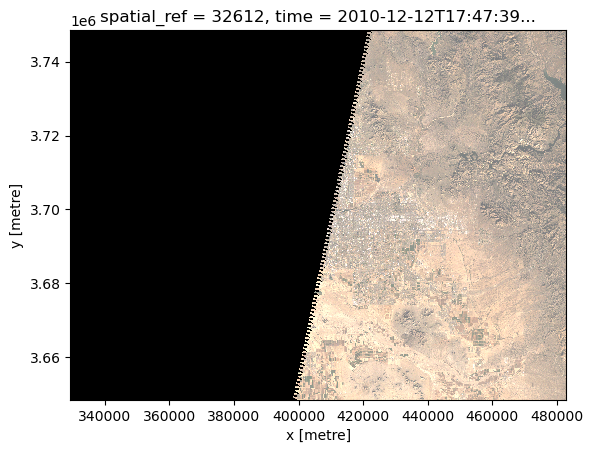

In [47]:
years = [2000, 2005, 2010, 2015, 2020]
year = 2010

search = catalog.search(
    collections=["landsat-c2-l2"],
    bbox=bbox,
    datetime=str(year),
    query={"eo:cloud_cover": {"lt": 10}},
)

items = search.item_collection()

selected_item = min(items, key=lambda item: eo.ext(item).cloud_cover)

data = odc.stac.stac_load(
    [selected_item], 
    bands=["red", "green", "blue"],
    bbox=bbox
)
data = data.squeeze()
data.to_array().plot.imshow(robust=True)

In [ ]:
# for key, asset in selected_item.assets.items():
#     print(f"{key}: {asset.title}")

In [43]:
data.to_array(dim='band')

<xarray.DataArray (band: 3, y: 3338, x: 5123)>
array([[[    0,     0,     0, ..., 10190, 10191, 10409],
        [    0,     0,     0, ..., 10625, 10843, 10843],
        [    0,     0,     0, ..., 10843, 10952, 11061],
        ...,
        [    0,     0,     0, ..., 13127, 13229, 12809],
        [    0,     0,     0, ..., 13334, 12914, 12388],
        [    0,     0,     0, ..., 11967, 11652, 11441]],

       [[    0,     0,     0, ...,  9597,  9721,  9844],
        [    0,     0,     0, ...,  9964, 10088, 10210],
        [    0,     0,     0, ..., 10208, 10209, 10331],
        ...,
        [    0,     0,     0, ..., 12055, 12052, 11698],
        [    0,     0,     0, ..., 11817, 11698, 11344],
        [    0,     0,     0, ..., 11343, 10870, 10870]],

       [[    0,     0,     0, ...,  8957,  9071,  8959],
        [    0,     0,     0, ...,  9069,  9403,  9293],
        [    0,     0,     0, ...,  9178,  9179,  9292],
        ...,
        [    0,     0,     0, ..., 10550, 10979, 10657],
        [    0,     0,     0, ..., 10333, 10441, 10226],
        [    0,     0,     0, ..., 10008,  9900,  9794]]], dtype=uint16)
Coordinates:
  * y            (y) float64 3.749e+06 3.749e+06 ... 3.648e+06 3.648e+06
  * x            (x) float64 3.293e+05 3.293e+05 ... 4.829e+05 4.83e+05
    spatial_ref  int32 32612
    time         datetime64[ns] 2000-12-24T17:48:17.190316
  * band         (band) object 'red' 'green' 'blue'

In [3]:
search = catalog.search(collections=["io-lulc-9-class"], 
                        bbox=bbox)
items = search.item_collection()
len(items)

6

6

In [39]:
data = stackstac.stack(
    items, 
    bounds_latlon=bbox,
    epsg=3857,
    resolution=100
)

data.shape

/srv/conda/envs/notebook/lib/python3.11/site-packages/stackstac/prepare.py:363: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


(6, 1, 1187, 1830)

In [40]:
x = data.compute()

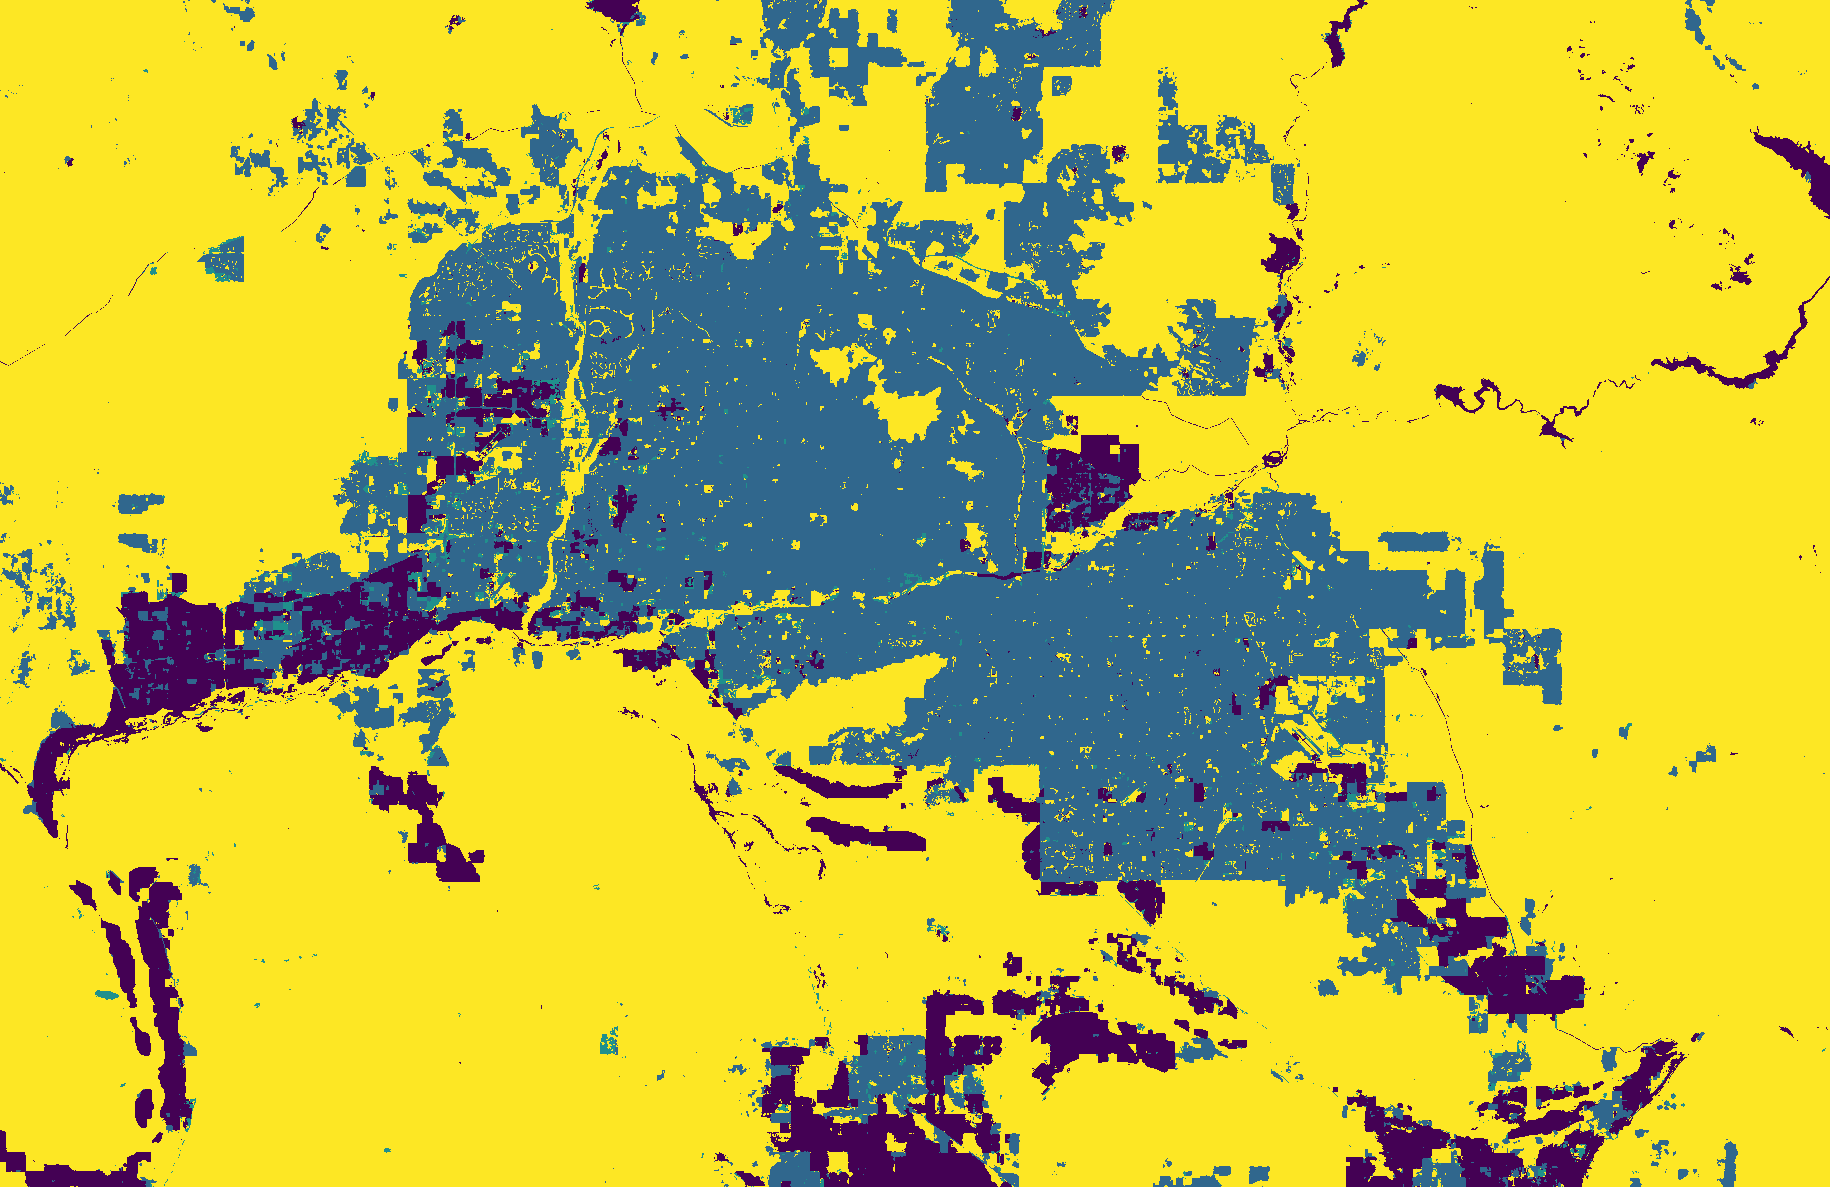

In [42]:
gif(x, date_format=None, fps=1)

In [55]:
items[0].properties['start_datetime']

'2022-01-01T00:00:00Z'

In [64]:
x = x.assign_coords(
    time=pd.to_datetime([item.properties['start_datetime'] for item in items])
    .tz_convert(None)).sortby("time")

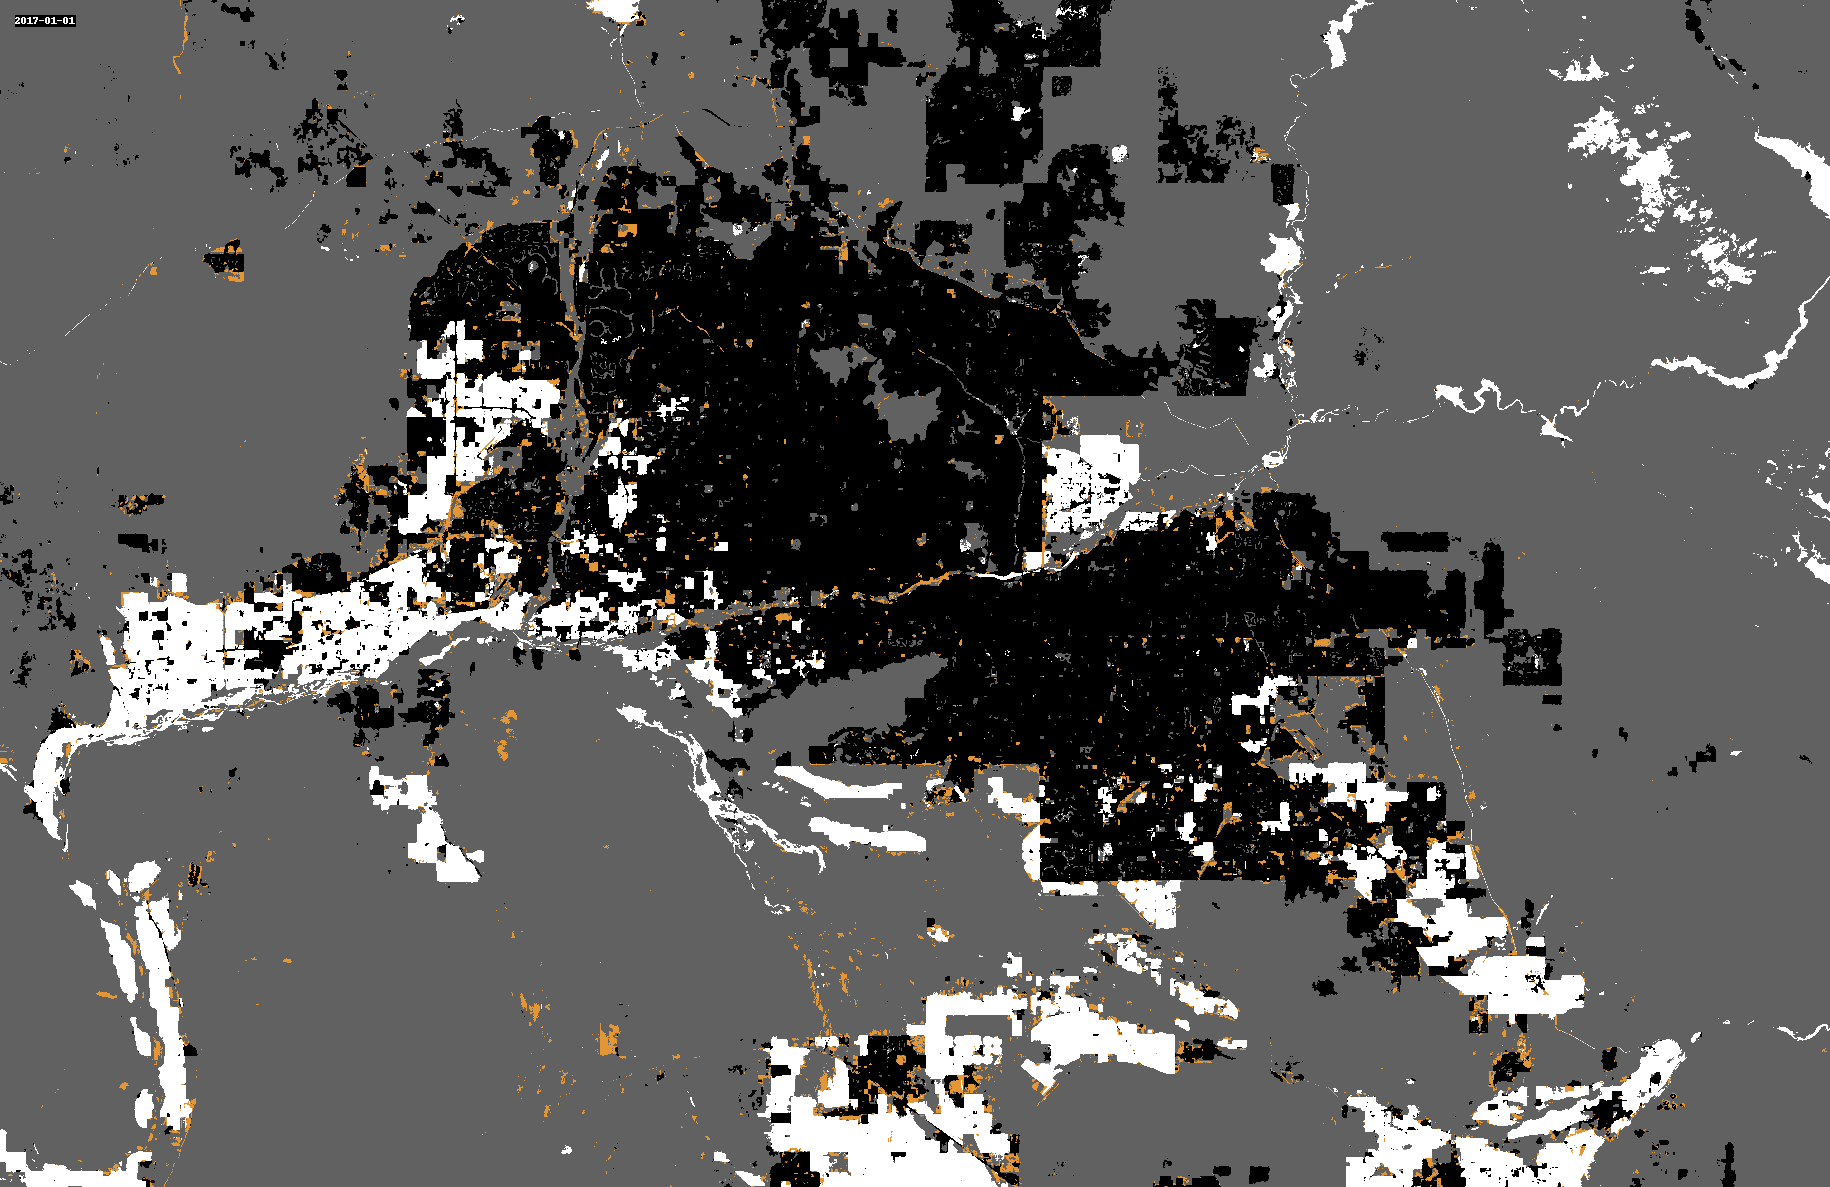

In [67]:
gif(x, fps=1, cmap=cmap)

In [68]:
from pystac.extensions.item_assets import ItemAssetsExtension
import numpy as np
from matplotlib.colors import ListedColormap


collection = catalog.get_collection("io-lulc-9-class")
ia = ItemAssetsExtension.ext(collection)

x = ia.item_assets["data"]
class_names = {x["summary"]: x["values"][0] for x in x.properties["file:values"]}
values_to_classes = {v: k for k, v in class_names.items()}
class_count = len(class_names)
class_names

{'No Data': 0,
 'Water': 1,
 'Trees': 2,
 'Flooded vegetation': 4,
 'Crops': 5,
 'Built area': 7,
 'Bare ground': 8,
 'Snow/ice': 9,
 'Clouds': 10,
 'Rangeland': 11}

In [69]:
item = items[0]
with rasterio.open(item.assets["data"].href) as src:
    colormap_def = src.colormap(1)  # get metadata colormap for band 1
    colormap = [
        np.array(colormap_def[i]) / 255 for i in range(max(class_names.values()))
    ]  # transform to matplotlib color format

cmap = ListedColormap(colormap)

In [66]:
type(cmap)

matplotlib.colors.ListedColormap

In [70]:
aoi = {"type": "Polygon",
       "coordinates": [
          [
            [-119.858400165532, 34.4226963083663],
            [-119.858400165532, 34.40190607560662],
            [-119.8348612171749, 34.40190607560662],
            [-119.8348612171749, 34.4226963083663],
            [-119.858400165532, 34.4226963083663]
          ]
        ]
      }

In [73]:
search = catalog.search(
    collections=["naip"], 
    intersects=aoi, 
    datetime='2012/2020'
)

In [81]:
items = search.item_collection()

In [77]:
bbox = [-119.8348612171749, 34.40190607560662, -119.858400165532, 34.4226963083663]

In [78]:
data = stackstac.stack(
    items, 
    bounds_latlon=bbox,
    epsg=3857,
    resolution=100
)

data.shape

/srv/conda/envs/notebook/lib/python3.11/site-packages/stackstac/prepare.py:363: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


(5, 1, 30, 27)

In [84]:
item = items[0]

In [85]:
sb = rioxr.open_rasterio(item.assets['image'].href)
sb

<xarray.DataArray (band: 4, y: 12500, x: 10580)>
[529000000 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3 4
  * x            (x) float64 2.354e+05 2.354e+05 ... 2.418e+05 2.418e+05
  * y            (y) float64 3.815e+06 3.815e+06 ... 3.807e+06 3.807e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:             Area
    TIFFTAG_IMAGEDESCRIPTION:  OrthoVista
    TIFFTAG_RESOLUTIONUNIT:    1 (unitless)
    TIFFTAG_SOFTWARE:          Trimble Germany GmbH
    TIFFTAG_XRESOLUTION:       1
    TIFFTAG_YRESOLUTION:       1
    _FillValue:                0
    scale_factor:              1.0
    add_offset:                0.0

In [86]:
sb.rio.clip_box(*bbox)

WindowError: Bounds and transform are inconsistent